# ....................Deep Learning for Computer Vision: Assignment 1.........................

                 Submitted by : Vivek Kumar Gautam, 22111069 & Gunj Hundiwala, 22111024
            


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
#Importing required libraries
import numpy as np
from numpy import save,load
import random
import math
import matplotlib.pyplot as plt
import time
import torch
import cv2
from sklearn.metrics import top_k_accuracy_score

## Solution to Q1. Download the CIFAR-10 dataset. Hint: Use pickle library to load the dataset.

In [ ]:
#Using pickle to read data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#path where test/train batches are saved
path = '/content/drive/MyDrive/Colab Notebooks/data/cifar-10-batches-py/data_batch_'
X_train= np.ones((1,3072))
Y_train= np.ones((1))

#loading train data 
for i in range(1,6) : 
    batch_dict = unpickle(path+str(i))
    dict_data = batch_dict[b'data']
    dict_labels = batch_dict[b'labels']
    X_temp = np.array(dict_data)
    Y_temp = np.array(dict_labels)
    X_train = np.append(X_train, X_temp , axis = 0)
    Y_train = np.append(Y_train,Y_temp , axis = 0 )

#loading train data 
batch_dict = unpickle('/content/drive/MyDrive/Colab Notebooks/data/cifar-10-batches-py/test_batch')
dict_data = batch_dict[b'data']
dict_labels = batch_dict[b'labels']
X_test = np.array(dict_data)
Y_test = np.array(dict_labels)

X_train = np.delete(X_train,0,0)
Y_train = np.delete(Y_train, 0 , 0)


In [ ]:
# Analyzing shapes of the Data and target
print('X_train Shape : ', X_train.shape , '\tY_train Shape : ', Y_train.shape ,'\nX_test Shape : ', X_test.shape  ,'\tY_test Shape : ', Y_test.shape   )

X_train Shape :  (50000, 3072) 	Y_train Shape :  (50000,) 
X_test Shape :  (10000, 3072) 	Y_test Shape :  (10000,)


## Solution to Ques 2.
### Q2.  Implement the image transformation methods mentioned below:
#### (a) Image Enhancement
#### (b) Posterization of Image
#### (c) Random Rotate [-180◦ , 180◦ ].
#### (d) Contrast & Horizontal flipping.

In [ ]:
def imEnhance(im):
    '''
    This function performs image enhancement for generating augmented data
    '''
    im = im.reshape((3,32,32))
    min = np.min(im)
    max = np.max(im)
    ime = np.int_(((im - min)/(max - min)) * 255)
    return ime.reshape((3072))

def posterize(im):
    '''
    This function performs image posterization for generating augmented data
    '''
    im = im.reshape((3,32,32))
    min = 50 
    max = 200
    r = max - min
    divider = 255/r
    level = (im/divider).astype(int)
    im2 = level + min
    return im2.reshape((3072))

def randomRotate(im, angle = [-180, 180]):
    '''
    This function takes an input image and generates a rotated image. The rotation angle is randomly selected from the given range.
    '''
    im = im.reshape((3,32,32))
    r = angle[1] - angle[0]
    degree = np.random.rand() * r + angle[0] #generate a random number in (0,1) and scale it to the given range.
    rad = np.radians(degree) #convert degrees to radians
    sine = np.sin(rad) 
    cosine = np.cos(rad)    
    height = im.shape[1]
    width  = im.shape[2]
    newImg = np.uint8(np.zeros(im.shape))  #initialise an empty array to hold the rotated image
    centrex = width//2 #
    centrey = height//2
    
    for x in range(width):
        for y in range(height):
            xnew= round((x-centrex)*cosine+(y-centrey)*sine) #find new position of each pixel after rotation aabout the centre
            ynew= round(-(x-centrex)*sine+(y-centrey)*cosine)

            xnew=xnew+centrex #go back to image coordinates
            ynew=ynew+centrey 

            if (0<xnew<width  and  0<ynew<height):
                newImg[:,ynew,xnew] = im[:,y,x]    
    return newImg.reshape((3072))

def contrastHflip(im):
    '''
    This function changes the contrast of an input image by a factor alpha and generates a horizontally flipped image with a probability of 0.5 .
    '''
    im = im.reshape((3,32,32))
    contrastRange = [0.5, 2.0]
    p = 0.5
    r = contrastRange[1] - contrastRange[0]
    alpha = np.random.rand() * r + contrastRange[0] #generate a random number in (0,1) and scale it to the given range.
    
    newImg = im #initialise an array to hold the contrast image
    newImg[:,:,:] = alpha * (im - 128) + 128 #contrast enhancement by a factor alpha
    
    #Clip the image to [0,255]
    newImg[newImg<0] = 0
    newImg[newImg>255] = 255
    
    newImg = newImg[:,::-1] if np.random.rand() > p else newImg
    return newImg.reshape((3072))

#### Visualizing Transformations on some Images

	ORIGINAL   	-  Enhanced	-		Posterized	-	  RandomRotate	  -  contrast&Horizontalflip


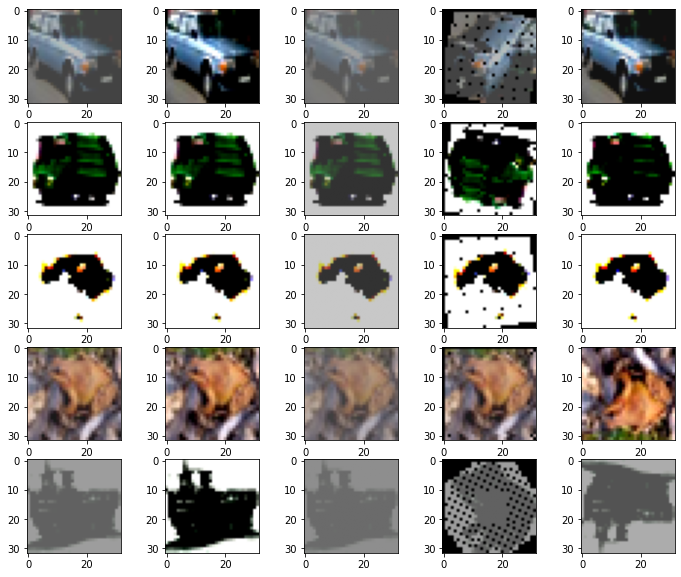

In [ ]:

fig = plt.figure(figsize=(12, 10),facecolor = 'white')
rows = 5
cols = 5
print("\tORIGINAL   \t-  Enhanced\t-\t\tPosterized\t-\t  RandomRotate\t  -  contrast&Horizontalflip")
for i in range(rows):
    orig = X_train[i+201]
    img  = np.transpose(X_train[i+201].reshape((3,32,32)) , (1,2,0))
    fig.add_subplot(rows, cols, i*5+1)
    plt.imshow(img/255.0 )
    
    fig.add_subplot(rows, cols, i*5+2)
    img = imEnhance(X_train[i+201])
    img  = np.transpose(img.reshape((3,32,32)) , (1,2,0))
    plt.imshow(img/255.0)
    
    fig.add_subplot(rows, cols, i*5+3)
    img = posterize(X_train[i+201])
    img  = np.transpose(img.reshape((3,32,32)) , (1,2,0))
    plt.imshow(img/255.0)
    
    fig.add_subplot(rows, cols, i*5+4)
    img = randomRotate(X_train[i+201])
    img  = np.transpose(img.reshape((3,32,32)) , (1,2,0))
    plt.imshow(img/255.0)
    
    
    fig.add_subplot(rows, cols, i*5+5)
    img = contrastHflip(X_train[i+201])
    img  = np.transpose(img.reshape((3,32,32)) , (1,2,0))
    plt.imshow(img/255.0)
    
        
plt.show()

## Solution to Q3.
### Q3.   Create the augmented training set using the transformation functions implemented in the previous part. Randomly select one of the four transformations for each image in the training set and apply it to that image. Combine the transformed images with original training set to get the augmented training set. 

In [ ]:
n = 50000

X_aug_train = np.zeros((50000,3072))
Y_aug_train = np.zeros((50000))
for i in range(n) : 
    p = random.uniform(0,1)
    if p < 0.25 :
        img = imEnhance(X_train[i])
    if p > 0.25 and  p < 0.5 :
        img = posterize(X_train[i])
    if p > 0.5 and p < 0.75 :
        img = randomRotate(X_train[i])
    if p >0.75 :
        img = contrastHflip(X_train[i])

    X_aug_train[i] = img 
    Y_aug_train[i] = Y_train[i]
    if not i%1000 :
        print(i, 'Images Augmented')

0 Images Augmented
1000 Images Augmented
2000 Images Augmented
3000 Images Augmented
4000 Images Augmented
5000 Images Augmented
6000 Images Augmented
7000 Images Augmented
8000 Images Augmented
9000 Images Augmented
10000 Images Augmented
11000 Images Augmented
12000 Images Augmented
13000 Images Augmented
14000 Images Augmented
15000 Images Augmented
16000 Images Augmented
17000 Images Augmented
18000 Images Augmented
19000 Images Augmented
20000 Images Augmented
21000 Images Augmented
22000 Images Augmented
23000 Images Augmented
24000 Images Augmented
25000 Images Augmented
26000 Images Augmented
27000 Images Augmented
28000 Images Augmented
29000 Images Augmented
30000 Images Augmented
31000 Images Augmented
32000 Images Augmented
33000 Images Augmented
34000 Images Augmented
35000 Images Augmented
36000 Images Augmented
37000 Images Augmented
38000 Images Augmented
39000 Images Augmented
40000 Images Augmented
41000 Images Augmented
42000 Images Augmented
43000 Images Augmented
4

In [ ]:
#appending original data/labels to augmented data/labels
X_aug_train = np.append(X_train, X_aug_train, axis = 0)
Y_aug_train = np.append(Y_train, Y_aug_train, axis = 0)
print(X_aug_train.shape , Y_aug_train.shape)

(100000, 3072) (100000,)


## Solution to Q4.
### Q4.   Use the feature extractor.py file provided with the assignment on the original (unaugmented) CIFAR-10 dataset and on the augmented dataset to get 1-dimensional input vectors.

In [ ]:
import feature_extractor
obj = feature_extractor.BBResNet18()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# resizing images to 224 img
def resize224(img):
    '''
    This function will take 3*32*32 size images and convert it into
    3*224*224 Images.
    this function will put a single pixels value to a window of size 7*7.
    As a result final image will be of 3*224*224
    '''
    batch = img.shape[0]
    img = img.reshape((batch,3,32,32))
    big_img = np.empty((batch,3,224,224))
    for i in range(32):
        for j in range(32):
            w = i*7
            h = j*7
            #print(big_img[:, :,w:w+7 , h:h+7].shape ,img[: , :,i,j].shape )
            big_img[:, :,w:w+7 , h:h+7]=img[: , :,i,j].reshape(batch, img.shape[1], 1, 1)
    return big_img

#### Extracting features for Augmented training set, Unaugmented Training Set and for Test Set

            Please note that running the cell below takes a lot of time. Hence, we have done the computation once and saved the extracted features which are being loaded in the next cell.
            

In [ ]:
%%time

n = X_aug_train.shape[0]
X_aug_feat_norm = np.zeros((n , 512))
for i in range(100):
    X_resized = np.zeros((1000,3,224,224))
    X_resized = resize224(X_aug_train[i*1000 : (i+1)*1000]).astype(np.float32)
    #resizing images
    X_resized /= 255.0
    #extracting features
    X_feat_temp = obj.feature_extraction(X_resized)
    X_aug_feat_norm[i*1000 : (i+1)*1000] = X_feat_temp
    
    print(i+1,X_feat_temp.shape)

    
n = X_train.shape[0]
X_feat_train_norm = np.zeros((n , 512))
for i in range(50):
    X_resized = np.zeros((1000,3,224,224))
    #resizing images
    X_resized = resize224(X_train[i*1000 : (i+1)*1000]).astype(np.float32)
    X_resized /= 255.0
    #extracting features
    X_feat_temp = obj.feature_extraction(X_resized)
    X_feat_train_norm[i*1000 : (i+1)*1000] = X_feat_temp
    
    print(i+1,X_feat_temp.shape)


n = X_test.shape[0]
X_feat_test_norm = np.zeros((n , 512))
for i in range(10):
    X_resized = np.zeros((1000,3,224,224))
    #Resizing images
    X_resized = resize224(X_test[i*1000 : (i+1)*1000]).astype(np.float32)
    X_resized /= 255.0
    #extracting Features
    X_feat_temp = obj.feature_extraction(X_resized)
    X_feat_test_norm[i*1000 : (i+1)*1000] = X_feat_temp
    
    print(i+1,X_feat_temp.shape)
  

#### Loading Extracted feature arrays  

In [ ]:
X_aug_feat_norm = load('/content/drive/MyDrive/Colab Notebooks/data/features/X_norm_aug_final.npy')
Y_aug_train = load('/content/drive/MyDrive/Colab Notebooks/data/features/Y_augmented_train.npy')


X_feat_train_norm = load('/content/drive/MyDrive/Colab Notebooks/data/features/X_norm_train_final.npy')
Y_train = load('/content/drive/MyDrive/Colab Notebooks/data/features/Y_train.npy')

X_feat_test_norm = load( '/content/drive/MyDrive/Colab Notebooks/data/features/X_norm_test_final.npy' )
Y_test = load( '/content/drive/MyDrive/Colab Notebooks/data/features/Y_test.npy' )

print('Size of Augmented(Train) Features and Labels : \t' , X_aug_feat_norm.shape , Y_aug_train.shape)
print('Size of Unaugmented(Train) Features and Labels : ' ,X_feat_train_norm.shape , Y_train.shape)
print('Size of Test Features and Labels :\t\t' ,X_feat_test_norm.shape , Y_test.shape)


Size of Augmented(Train) Features and Labels : 	 (100000, 512) (100000,)
Size of Unaugmented(Train) Features and Labels :  (50000, 512) (50000,)
Size of Test Features and Labels :		 (10000, 512) (10000,)


##  Solution to Q5.
### Q5. Implement a multi-layer perceptron (MLP) for classification of CIFAR-10 images. Use two hidden layer with 64 neurons each and ReLu activation function. The input to this MLP will be the 1-dimensional vectors generated in the previous step.

#### Creating One-Hot vectors : 

In [ ]:
#creating one hot vectors : 
y_hot_train = np.zeros((X_feat_train_norm.shape[0] , 10))
for i in range(X_feat_train_norm.shape[0]):
    y_hot_train[i, int(Y_train[i])] = 1



y_hot_aug = np.zeros((X_aug_feat_norm.shape[0], 10))
for i in range(X_aug_feat_norm.shape[0]):
    y_hot_aug[i, int(Y_aug_train[i])] = 1



y_hot_test = np.zeros((Y_test.shape[0], 10))
for i in range(Y_test.shape[0]):
    y_hot_test[i, int(Y_test[i])] = 1

print('Size of Y-hot vector Unaugmented Train : ',y_hot_train.shape)
print('Size of Y-hot vector Augmented Train : ',y_hot_aug.shape)
print('Size of Y-hot vector Test  : \t\t',y_hot_test.shape)

Size of Y-hot vector Unaugmented Train :  (50000, 10)
Size of Y-hot vector Augmented Train :  (100000, 10)
Size of Y-hot vector Test  : 		 (10000, 10)


In [ ]:
def relu(x): 
    temp = np.copy(x)
    #claculating indices where input is less than zero
    idx = np.where(temp < 0)
    #setting values of such indices(above step) to 0
    temp[idx] = 0
    
    return temp

def relugrad(x):
    '''
    This function of return 0 if input is less than 0
    and 1 if input is more than Zero.
    '''
    temp = np.copy(x)
    
    idx = np.where(temp <= 0)
    idx2 = np.where(temp > 0)

    temp[idx] = 0
    temp[idx2] = 1
    
    return temp


def cross_entropy_loss(y , y_pred) : 
    logs = np.log(y_pred)
    return np.sum(-1*y*logs)/float(y.shape[0]) 

def softmax(y_pred) :
    y_max = np.max(y_pred, axis = 1)
    y_pred = np.exp(y_pred)
    y_sum = np.sum(y_pred, axis = 1)
    
    return (y_pred.T/y_sum).T

def accuracy(y,y_):
    y_label = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_ , axis = 1)
    correct = np.sum(y_label == y_pred)
    return correct

    

#### Setting up Model Hyperparameters

In [ ]:
input_size = 512 #size of Input array
layers = [64,64] #Array to store size of each hidden layer
output_size = 10 #size of classes/output of softmax
degradation_rate = 0.9 # Learning Rate degradation Rate
learning_rate = 0.01 # Learning Rate
epoch = 200 # No.s of epochs
batch_size = 64 # batch size

#### Defining Neural Network Class

In [ ]:
class NeuralNetwork:
    
    def __init__(self, input_size , layers , output_size):
        '''
        Constructor to initialize weights and biases
        '''
        np.random.seed(0)
        model = {} # creating a dictionary for the network
        
        #initializing weight and biases
        model['W1'] = np.random.randn(input_size,layers[0])*0.001
        model['W2'] = np.random.randn(layers[0],layers[1])*0.001
        model['W3'] = np.random.randn(layers[1],output_size)*0.001
        model['b1'] = np.random.randn(1, layers[0])*0.01
        model['b2'] = np.random.randn(1, layers[1])*0.01
        model['b3'] = np.random.randn(1, output_size)*0.01
        self.model = model#saving model dictionary
        
    def forward(self , x) : 
        '''
        This Function will implement Forward pass on the data
        '''
        #loading weights and biases from model dictionary
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        #taking dot product of Input features and weight matrix
        z1 = np.dot(x,W1) + b1
        #applying Activation(ReLU) of the output of neurons 
        a1 = relu(z1)

        #taking dot product of Input features and weight matrix
        z2 = np.dot(a1,W2) + b2
        #applying Activation(ReLU) of the output of neurons 
        a2 = relu(z2)
        
        z3 = np.dot(a2, W3) + b3
        #taking softmax of outputs of neurons
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
    
    def backward(self , X, y , learning_rate = 0.001) :
        '''
        Function to implement Backward pass
        '''
        #loading weights and biases from model dictionary
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = X.shape[0]
        #loading this iterations outputs and activations 
        a1,a2,y_ = self.activation_outputs
        #calculating gradient of loss wrt W3
        delta3 = y_ - y

        dw3 = np.dot(a2.T,delta3)/float(m)
        db3 = np.sum(delta3 , axis = 0,keepdims = True)/float(m)

        a2[a2>0] = 1
        g2 = a2
        delta2 = np.dot(delta3, W3.T) * g2
        dw2 = np.dot(a1.T,delta2)/float(m)
        db2 = np.sum(delta2 , axis = 0,keepdims = True)/float(m)
        
        delta1 = relugrad(a1)*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1  )/float(m)
        db1 = np.sum(delta1 , axis=0,keepdims = True)/float(m)
        
        #updating Weights and Biases
        self.model['W1'] -= (learning_rate*dw1)
        self.model['b1'] -= (learning_rate*db1)
        self.model['W2'] -= (learning_rate*dw2)
        self.model['b2'] -= (learning_rate*db2)
        self.model['W3'] -= (learning_rate*dw3)
        self.model['b3'] -= (learning_rate*db3)
    
    def summary(self, act = False) :
        '''
        Function to Know Shape of Learnable parameters 
        '''
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        print( "W1 : " , W1.shape)
        print( "b1 : " , b1.shape)
        if act : 
            a1,y_ = self.activation_outputs
            print( "a1 : " , a1.shape)

        print( "W2 : " , W2.shape)
        print( "b2 : " , b2.shape)
        if act : 
            a1,y_ = self.activation_outputs
            print( "a2 : " , a2.shape)

        print( "W3 : " , W3.shape)
        print( "b3 : " , b3.shape)
        if act :
            print( "Y_ : " , y_.shape)
        return
    
    
    def minmaxweights(self):
        '''
        This function is Used to return range of weights and biases
        '''
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1,b2,b3 = self.model['b1'],self.model['b2'],self.model['b3']
        print( 'W1 : ' )
        print( np.max(W1), np.min(W1) )
        print( 'W2 : ' )
        print( np.max(W2), np.min(W2) )
        print( 'W3 : ' )
        print( np.max(W3), np.min(W3) )
        print( 'b1 : ' )
        print( np.max(b1), np.min(b1) )
        print( 'b2 : ' )
        print( np.max(b2), np.min(b2) )
        print( 'b3 : ' )
        print( np.max(b3), np.min(b3) )
    
    def saveweights(self,sub = 'params'):
        '''
        This function will store models weights in the 'params' folder
        with subscript = 'sub'
        '''
        save('/content/drive/MyDrive/Colab Notebooks/data/params/w1_' + sub +'.npy' , self.model['W1'])
        save('/content/drive/MyDrive/Colab Notebooks/data/params/w2_' + sub +'.npy' , self.model['W2'])
        save('/content/drive/MyDrive/Colab Notebooks/data/params/w3_' + sub +'.npy' , self.model['W3'])
        save('/content/drive/MyDrive/Colab Notebooks/data/params/b1_' + sub +'.npy' , self.model['b1'])
        save('/content/drive/MyDrive/Colab Notebooks/data/params/b2_' + sub +'.npy' , self.model['b2'])
        save('/content/drive/MyDrive/Colab Notebooks/data/params/b3_' + sub +'.npy' , self.model['b3'])
        
    def loadweights(self, w1,w2,w3,b1,b2,b3):
        '''
        This function will change weights and biases 
        '''
        self.model['W1'] = w1
        self.model['W2'] = w2
        self.model['W3'] = w3
        self.model['b1'] = b1
        self.model['b2'] = b2
        self.model['b3'] = b3

In [ ]:
 def train(X,Y,X_test,Y_test,model,epochs = 1, batch_size = 32 , learning_rate = 0.008,logs = True,degradation_rate=1, test_acc_list = [],epoch_loss=[],epoch_acc = []):
        
    #calculating no. of iteratons 
    iters = round(X.shape[0]/batch_size)
    
    
    for i in range(epochs):
        e_loss = 0 
        correct = 0
        #shuffling data in every epoch, so that every data point is used in some epoch
        idx = np.random.permutation(X.shape[0])
        X , Y = X[idx] , Y[idx]
        for ix in range(iters):
            
            #creating Data and labels batch
            X_batch = X[ix*batch_size : (ix+1)*batch_size]
            Y_batch = Y[ix*batch_size : (ix+1)*batch_size]
            y_ = model.forward(X_batch)
            
            model.backward(X_batch,Y_batch,learning_rate)
            local_loss = cross_entropy_loss(Y_batch , y_)
            #calculating correct labels
            correct+=accuracy(Y[ix*batch_size : (ix+1)*batch_size] , y_)
            #adding epoch loss 
            e_loss+=local_loss
            
            
        
        #checking Test Dataset Accuracy
        y_test_pred = model.forward(X_test)
        test_correct = accuracy(y_test_pred, Y_test)
        test_acc = test_correct*100/Y_test.shape[0]
        train_acc = (correct*100)/float(iters*batch_size)
        
        #appending the values calculated for analysing later on
        test_acc_list.append(test_acc)
        epoch_loss.append(e_loss/float(iters))
        epoch_acc.append(train_acc)
        
        ## degrading Learning Rate after every 20 epochs
        if (i+1)%20 == 0 and learning_rate > 0.0001:
            learning_rate *=degradation_rate 
            print('learning rate updated : ' , learning_rate)
            print('------------------------------------')
        ## printing Loss and Accuracy 
        if logs and i%10==0:
            print("Epoch: %d loss %.4f Training acc %.4f Testing acc %.4f"%(i+1,local_loss,train_acc,test_acc ))
                #print('____________________________')
    

## Solution to Q6(a)
### Q6(a). Implement the back-propagation algorithm and use it to train the MLP model on original training set.

In [ ]:
## Creating Object of neural Network Class for Unaugmented Data
model = NeuralNetwork(input_size , layers , output_size)
model.summary()

W1 :  (512, 64)
b1 :  (1, 64)
W2 :  (64, 64)
b2 :  (1, 64)
W3 :  (64, 10)
b3 :  (1, 10)


In [ ]:
# Empty Lists to store Per Epoch Data for analysis 
epoch_loss = []
test_acc_list = []
epoch_acc = []


In [ ]:
%%time
train(X_feat_train_norm, y_hot_train, X_feat_test_norm, y_hot_test,
      model ,epoch, batch_size, learning_rate, True,
      degradation_rate, test_acc_list, epoch_loss, epoch_acc)

Epoch: 1 loss 2.3031 Training acc 9.9952 Testing acc 10.0000
Epoch: 11 loss 2.3028 Training acc 9.6951 Testing acc 10.0000
learning rate updated :  0.009000000000000001
------------------------------------
Epoch: 21 loss 2.3027 Training acc 9.7891 Testing acc 10.0000
Epoch: 31 loss 2.2264 Training acc 15.2789 Testing acc 16.2500
learning rate updated :  0.008100000000000001
------------------------------------
Epoch: 41 loss 1.4649 Training acc 36.8778 Testing acc 37.6500
Epoch: 51 loss 0.8508 Training acc 62.2879 Testing acc 62.4200
learning rate updated :  0.007290000000000001
------------------------------------
Epoch: 61 loss 0.9704 Training acc 69.4762 Testing acc 69.5500
Epoch: 71 loss 0.6848 Training acc 73.5655 Testing acc 73.0800
learning rate updated :  0.006561000000000002
------------------------------------
Epoch: 81 loss 0.7163 Training acc 75.8323 Testing acc 74.0900
Epoch: 91 loss 0.5891 Training acc 77.4528 Testing acc 75.8300
learning rate updated :  0.005904900000000

## Solution to Q6(b)
### Q6(b). Implement the back-propagation algorithm and use it to train the MLP model on augmented training set.

In [ ]:
# Creating object of class Neural Network for Augmented Data
model_aug = NeuralNetwork(input_size , layers , output_size)
model_aug.summary()



W1 :  (512, 64)
b1 :  (1, 64)
W2 :  (64, 64)
b2 :  (1, 64)
W3 :  (64, 10)
b3 :  (1, 10)


In [ ]:
# Empty Arrays to store results
epoch_loss_aug = []
test_acc_list_aug = []
epoch_acc_aug = []

In [ ]:
%%time
train(X_aug_feat_norm, y_hot_aug, X_feat_test_norm, y_hot_test, 
      model_aug ,epoch, batch_size, learning_rate, True,
      degradation_rate,test_acc_list_aug, epoch_loss_aug, epoch_acc_aug)

Epoch: 1 loss 2.3025 Training acc 9.9052 Testing acc 10.0000
Epoch: 11 loss 2.3024 Training acc 9.9192 Testing acc 10.0000
learning rate updated :  0.009000000000000001
------------------------------------
Epoch: 21 loss 1.5212 Training acc 31.8102 Testing acc 33.5000
Epoch: 31 loss 0.9619 Training acc 62.2349 Testing acc 68.1400
learning rate updated :  0.008100000000000001
------------------------------------
Epoch: 41 loss 0.9107 Training acc 69.1901 Testing acc 73.6800
Epoch: 51 loss 0.6284 Training acc 71.7089 Testing acc 76.4000
learning rate updated :  0.007290000000000001
------------------------------------
Epoch: 61 loss 0.7557 Training acc 73.3625 Testing acc 76.2300
Epoch: 71 loss 0.7916 Training acc 74.4688 Testing acc 76.7300
learning rate updated :  0.006561000000000002
------------------------------------
Epoch: 81 loss 0.6547 Training acc 75.4822 Testing acc 77.5600
Epoch: 91 loss 0.8651 Training acc 76.2554 Testing acc 77.8000
learning rate updated :  0.00590490000000

## Solution to Q8(a)
### Q8(a). Evaluate the performance of the trained MLP models on both the original (unaugmented) test set and augmented test set for top 5 classification

In [ ]:
y_pred = model.forward(X_feat_test_norm) #doing forward pass on Test Data after All the Epochs on 
                                         #model trained on Unaugmented Data
correct = accuracy (y_pred , y_hot_test)
print('Testing Accuracy using Unaugmented Dataset',correct*100/Y_test.shape[0])

Testing Accuracy using Unaugmented Dataset 77.57


## Solution to Ques 7. b)

In [ ]:

y_aug_pred = model_aug.forward(X_feat_test_norm)#doing forward pass on Test Data after All the Epochs on 
                                                 #model trained on Augmented Data
correct = accuracy (y_aug_pred , y_hot_test)
print('Testing Accuracy using Augmented Dataset',correct*100/Y_test.shape[0])

Testing Accuracy using Augmented Dataset 77.36


In [ ]:
# Comparing the Highest Accuracy achieved During Training of the Two Models
print('Maximum Test Accuracy achieved while training in Unaugmented Dataset: ',max(test_acc_list))
print('Maximum Test Accuracy achieved while training in Augmented Dataset: ',max(test_acc_list_aug))


Maximum Test Accuracy achieved while training in Unaugmented Dataset:  78.04
Maximum Test Accuracy achieved while training in Augmented Dataset:  78.21


#### Visualizing Results

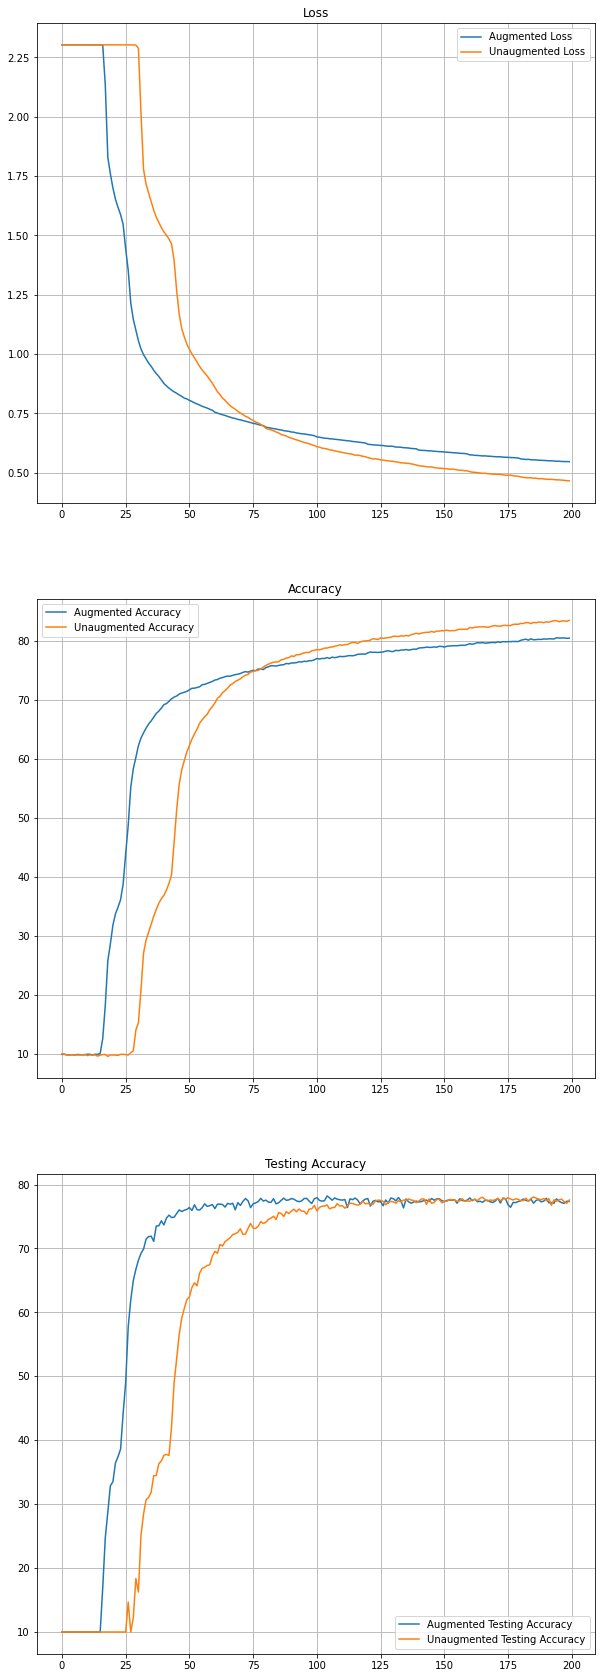

In [ ]:
fig = plt.figure(figsize=(10, 30), facecolor = 'white')
rows = 3
cols = 1
#rect.set_facecolor('red')
fig.add_subplot(rows, cols, 1)
plt.plot(epoch_loss_aug, label = 'Augmented Loss')
plt.plot(epoch_loss, label = 'Unaugmented Loss')
plt.legend()
plt.grid()
plt.title('Loss')
#plt.show()
fig.add_subplot(rows, cols, 2)
plt.plot(epoch_acc_aug,label = 'Augmented Accuracy')
plt.plot(epoch_acc,label = 'Unaugmented Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')
#plt.show()
fig.add_subplot(rows, cols, 3)
plt.plot(test_acc_list_aug, label = 'Augmented Testing Accuracy')
plt.plot(test_acc_list, label = 'Unaugmented Testing Accuracy')
plt.legend()
plt.grid()
plt.title('Testing Accuracy')
plt.show()